In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from flaml import AutoML
import xgboost as xgb
from sklearn.linear_model import LinearRegression


xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
file_path = 'combined_dataset.nc'
combined_dataset = xr.open_dataset(file_path)

C:\Users\HP\anaconda3\envs\myenv\Lib\site-packages\ecmwflibs\__init__.py:81: UserWarning: DLL load failed while importing _ecmwflibs: 找不到指定的程序。
  warnings.warn(str(e))
C:\Users\HP\anaconda3\envs\myenv\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
df = combined_dataset.to_dataframe().reset_index()

In [4]:
clean_df = df.dropna()

In [5]:
df = clean_df

In [6]:
#deal with time information
df['time'] = df['time'].astype(str)
df['time'] = pd.to_datetime(df['time'])

In [7]:
#Split time to year, month, day of year
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['dayofyear'] = df['time'].dt.dayofyear

In [8]:
df['WindSpeed'] = np.sqrt(df['UBOT']**2 + df['VBOT']**2)

In [9]:
#water_vapor_content
P = 101325 
R = 287.05
df['WaterVapor'] =  (df['QBOT'] * P) / ( R * df['TREFHT'])

In [10]:
#heat_flux
rho = 1.225 
Cp = 1005 
df['HeatFlux'] = rho * Cp * df['TREFHT'] * df['WindSpeed']

In [11]:
#split train and test
train = df[df['year'] < 2040]
valid = df[(df['year'] >= 2040) & (df['year'] < 2050)]
test = df[df['year'] >= 2050]

In [12]:
#train and X_test
X_train = train.drop(['TREFMXAV_U','source','time'], axis=1) 
y_train = train['TREFMXAV_U']
X_valid = valid.drop(['TREFMXAV_U','source','time'], axis=1) 
y_valid = valid['TREFMXAV_U']
X_test = test.drop(['TREFMXAV_U','source','time'], axis=1) 
y_test = test['TREFMXAV_U']

In [13]:
model = xgb.Booster()
model.load_model('xgb_model.bin')

In [14]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
y_pred = model.predict(dtest)
test['predict'] = y_pred

C:\Users\HP\AppData\Local\Temp\ipykernel_14116\3376358597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict'] = y_pred


In [15]:
#y_test = test['TREFMXAV_U']
y_test_pred = test['predict']

In [16]:
#mse = mean_squared_error(y_test_mean, y_test_pred)
#mae = mean_absolute_error(y_test_mean, y_test_pred)
#r2 = r2_score(y_test_mean, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
rmse = sqrt(mse)



print(f'Validation Mean Squared Error (MSE): {mse}')
print(f'Validation Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Validation R-squared: {r2}')

Validation Mean Squared Error (MSE): 0.5135531425476074
Validation Mean Absolute Error (MAE): 0.5262275338172913
Root Mean Squared Error (RMSE): 0.7166262223416106
Validation R-squared: 0.9824598186772603


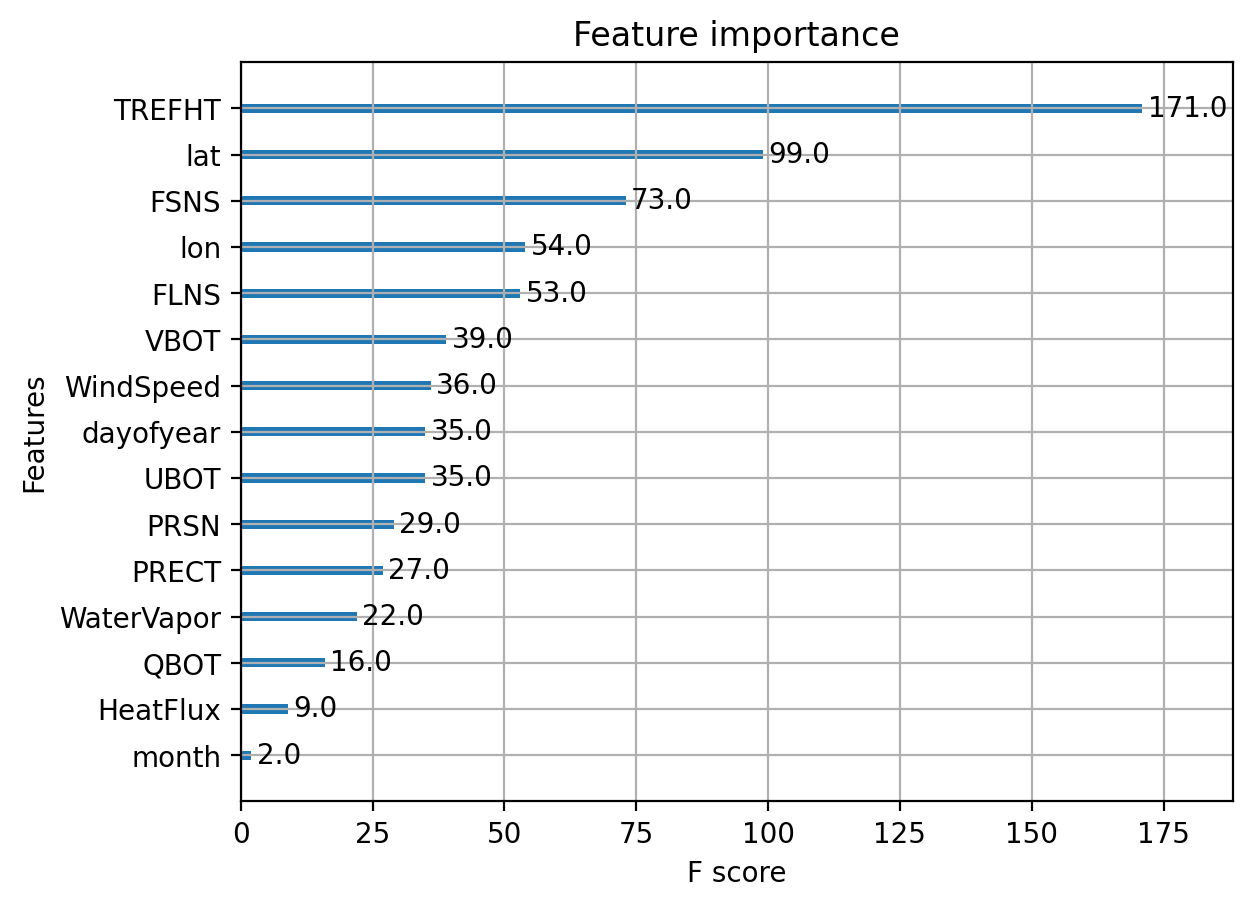

In [17]:
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror'
}
num_round = 100

bst = xgb.train(params, dtrain, num_round)

# feature importance
xgb.plot_importance(bst)
plt.show()

In [18]:
#city
test['city_group'] = test.apply(lambda row: f"{row['lat']}, {row['lon']}", axis=1)
grouped = test.groupby('city_group')
rmse_results = {}
for name, group in grouped:
    rmse = np.sqrt(mean_squared_error(group['TREFMXAV_U'], group['predict']))
    rmse_results[name] = rmse

C:\Users\HP\AppData\Local\Temp\ipykernel_14116\3680442530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['city_group'] = test.apply(lambda row: f"{row['lat']}, {row['lon']}", axis=1)


In [19]:
sorted_rmse = sorted(rmse_results.items(), key=lambda x: x[1])

In [20]:
sorted_rmse

[('52.30366516113281, 352.5', 0.61903626),
 ('57.95811462402344, 353.75', 0.620889),
 ('56.073299407958984, 355.0', 0.62974465),
 ('53.24607467651367, 353.75', 0.64255434),
 ('58.9005241394043, 356.25', 0.64382875),
 ('53.24607467651367, 355.0', 0.6502719),
 ('53.24607467651367, 352.5', 0.65177196),
 ('52.30366516113281, 356.25', 0.6555918),
 ('51.36125564575195, 356.25', 0.65589666),
 ('55.130889892578125, 355.0', 0.6590231),
 ('53.24607467651367, 357.5', 0.65907854),
 ('53.24607467651367, 356.25', 0.6598719),
 ('57.95811462402344, 358.75', 0.6612783),
 ('56.073299407958984, 356.25', 0.6650049),
 ('50.41884994506836, 355.0', 0.6680273),
 ('57.01570510864258, 357.5', 0.6682692),
 ('57.95811462402344, 356.25', 0.67068857),
 ('54.188480377197266, 352.5', 0.6713386),
 ('55.130889892578125, 356.25', 0.6729769),
 ('55.130889892578125, 352.5', 0.67319286),
 ('55.130889892578125, 353.75', 0.673254),
 ('56.073299407958984, 357.5', 0.6760973),
 ('54.188480377197266, 356.25', 0.67716956),
 ('54.

In [21]:
for city, rmse in sorted_rmse:
    print(f"City ({city}) RMSE: {rmse:.3f}")

City (52.30366516113281, 352.5) RMSE: 0.619
City (57.95811462402344, 353.75) RMSE: 0.621
City (56.073299407958984, 355.0) RMSE: 0.630
City (53.24607467651367, 353.75) RMSE: 0.643
City (58.9005241394043, 356.25) RMSE: 0.644
City (53.24607467651367, 355.0) RMSE: 0.650
City (53.24607467651367, 352.5) RMSE: 0.652
City (52.30366516113281, 356.25) RMSE: 0.656
City (51.36125564575195, 356.25) RMSE: 0.656
City (55.130889892578125, 355.0) RMSE: 0.659
City (53.24607467651367, 357.5) RMSE: 0.659
City (53.24607467651367, 356.25) RMSE: 0.660
City (57.95811462402344, 358.75) RMSE: 0.661
City (56.073299407958984, 356.25) RMSE: 0.665
City (50.41884994506836, 355.0) RMSE: 0.668
City (57.01570510864258, 357.5) RMSE: 0.668
City (57.95811462402344, 356.25) RMSE: 0.671
City (54.188480377197266, 352.5) RMSE: 0.671
City (55.130889892578125, 356.25) RMSE: 0.673
City (55.130889892578125, 352.5) RMSE: 0.673
City (55.130889892578125, 353.75) RMSE: 0.673
City (56.073299407958984, 357.5) RMSE: 0.676
City (54.18848

In [22]:
data = {
    'city_group': [x[0] for x in sorted_rmse],
    'rmse': [x[1] for x in sorted_rmse]
}
city = pd.DataFrame(data)
city[['lat', 'lon']] = city['city_group'].str.split(',', expand=True).astype(float)

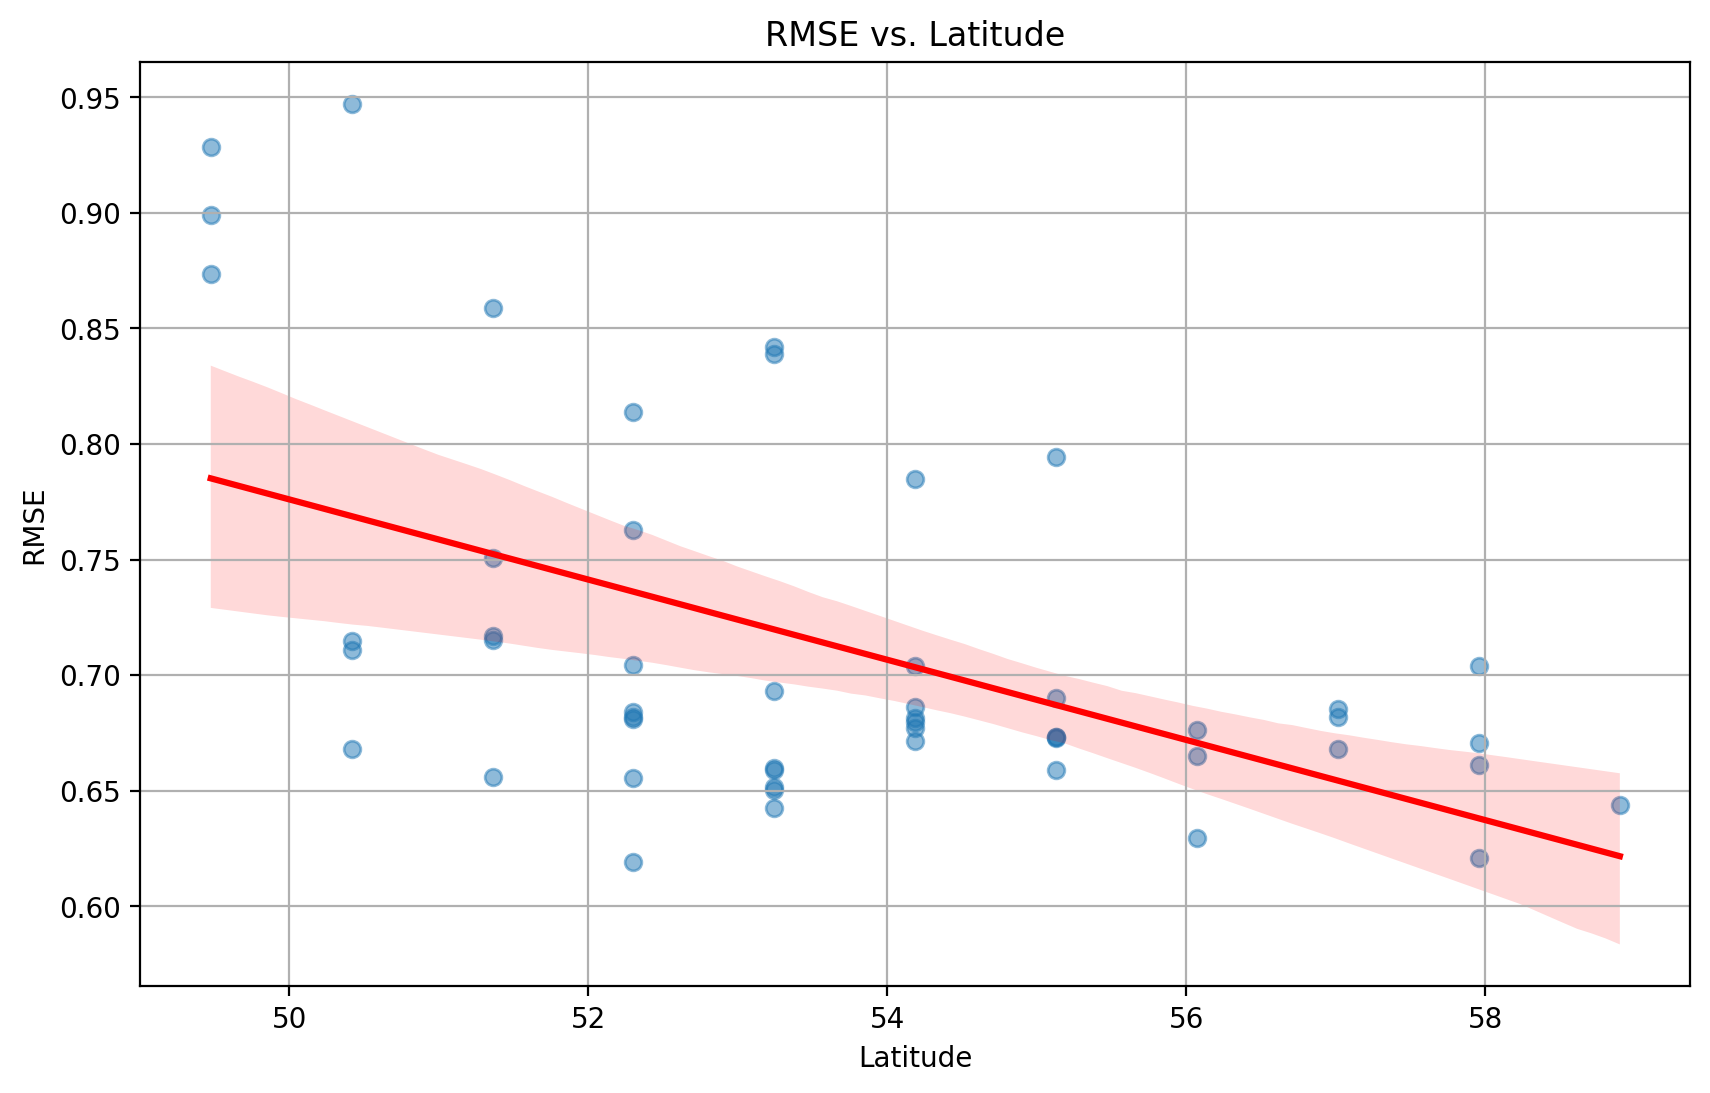

In [23]:
plt.figure(figsize=(10, 6))
sns.regplot(x='lat', y='rmse', data=city, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
#plt.scatter(city['lat'], city['rmse'])
plt.xlabel('Latitude')
plt.ylabel('RMSE')
plt.title('RMSE vs. Latitude')
plt.grid(True)
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_14116\2042622191.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_city = city.groupby(pd.cut(city['lat'], bins=np.arange(49, 60, 1)))['rmse'].mean().reset_index()


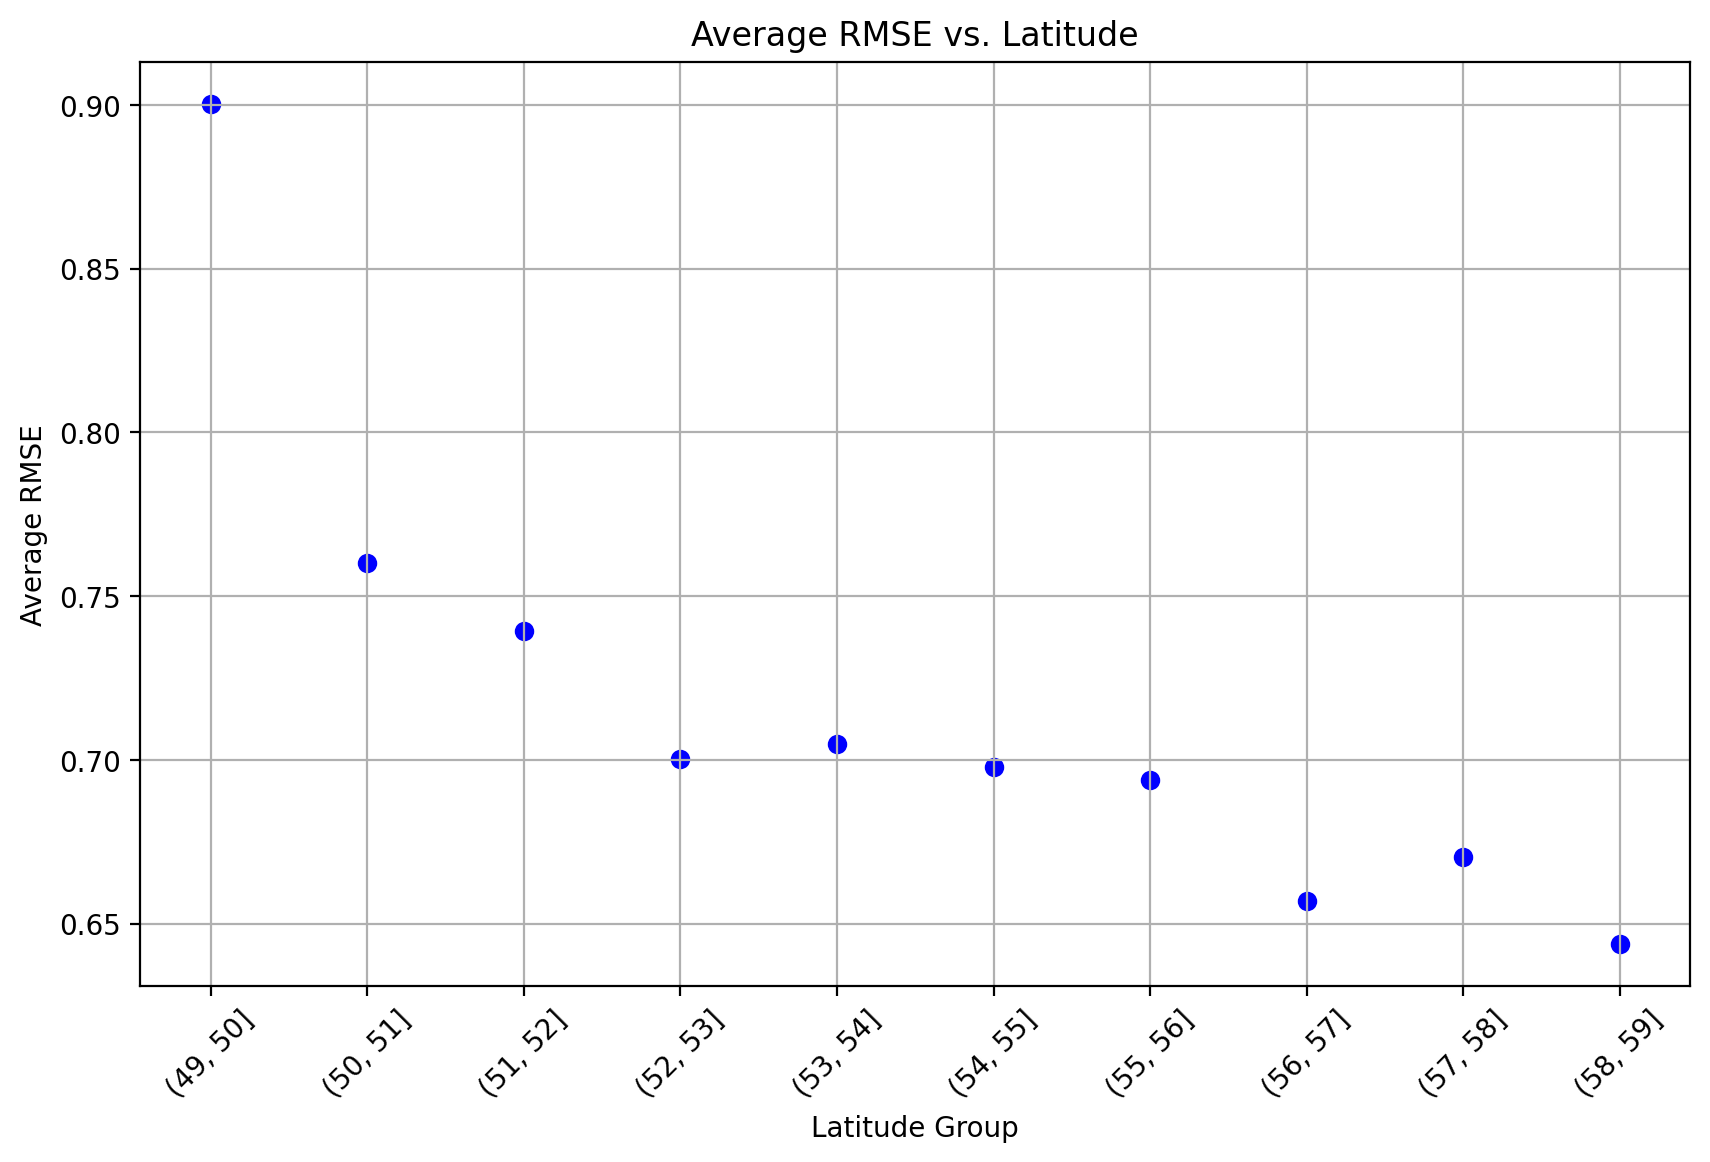

In [24]:

grouped_city = city.groupby(pd.cut(city['lat'], bins=np.arange(49, 60, 1)))['rmse'].mean().reset_index()


plt.figure(figsize=(10, 6))
plt.scatter(grouped_city['lat'].astype(str), grouped_city['rmse'], color='blue')
plt.title('Average RMSE vs. Latitude')
plt.xlabel('Latitude Group')
plt.ylabel('Average RMSE')
plt.xticks(rotation=45)  
plt.grid(True)
plt.show()

In [26]:
#seasons
def assign_season(month):
    if month in (12, 1, 2):
        return 'Winter'
    elif month in (3, 4, 5):
        return 'Spring'
    elif month in (6, 7, 8):
        return 'Summer'
    else:
        return 'Autumn'

test['season'] = test['month'].apply(assign_season)
seasonal_rmse = test.groupby('season').apply(
    lambda x: np.sqrt(mean_squared_error(x['TREFMXAV_U'], x['predict']))
)


C:\Users\HP\AppData\Local\Temp\ipykernel_14116\2225480600.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['season'] = test['month'].apply(assign_season)


In [27]:
seasonal_rmse

season
Autumn    0.618657
Spring    0.745600
Summer    0.772733
Winter    0.719093
dtype: float32

In [30]:
def get_extreme_days(test, year, n=10):
    hottest_days = test[test['year'] == year].nlargest(n, 'TREFMXAV_U')
    coldest_days = test[test['year'] == year].nsmallest(n, 'TREFMXAV_U')
    return hottest_days, coldest_days

def calculate_rmse(true_values, predictions):
    return np.sqrt(mean_squared_error(true_values, predictions))

years = test['year'].unique()
results = []
for year in years:
    hottest_days, coldest_days = get_extreme_days(test, year)
    
    hottest_rmse = calculate_rmse(hottest_days['TREFMXAV_U'], hottest_days['predict'])
    coldest_rmse = calculate_rmse(coldest_days['TREFMXAV_U'], coldest_days['predict'])
    
    results.append({
        'year': year,
        'hottest_rmse': hottest_rmse,
        'coldest_rmse': coldest_rmse
    })

results_df = pd.DataFrame(results)

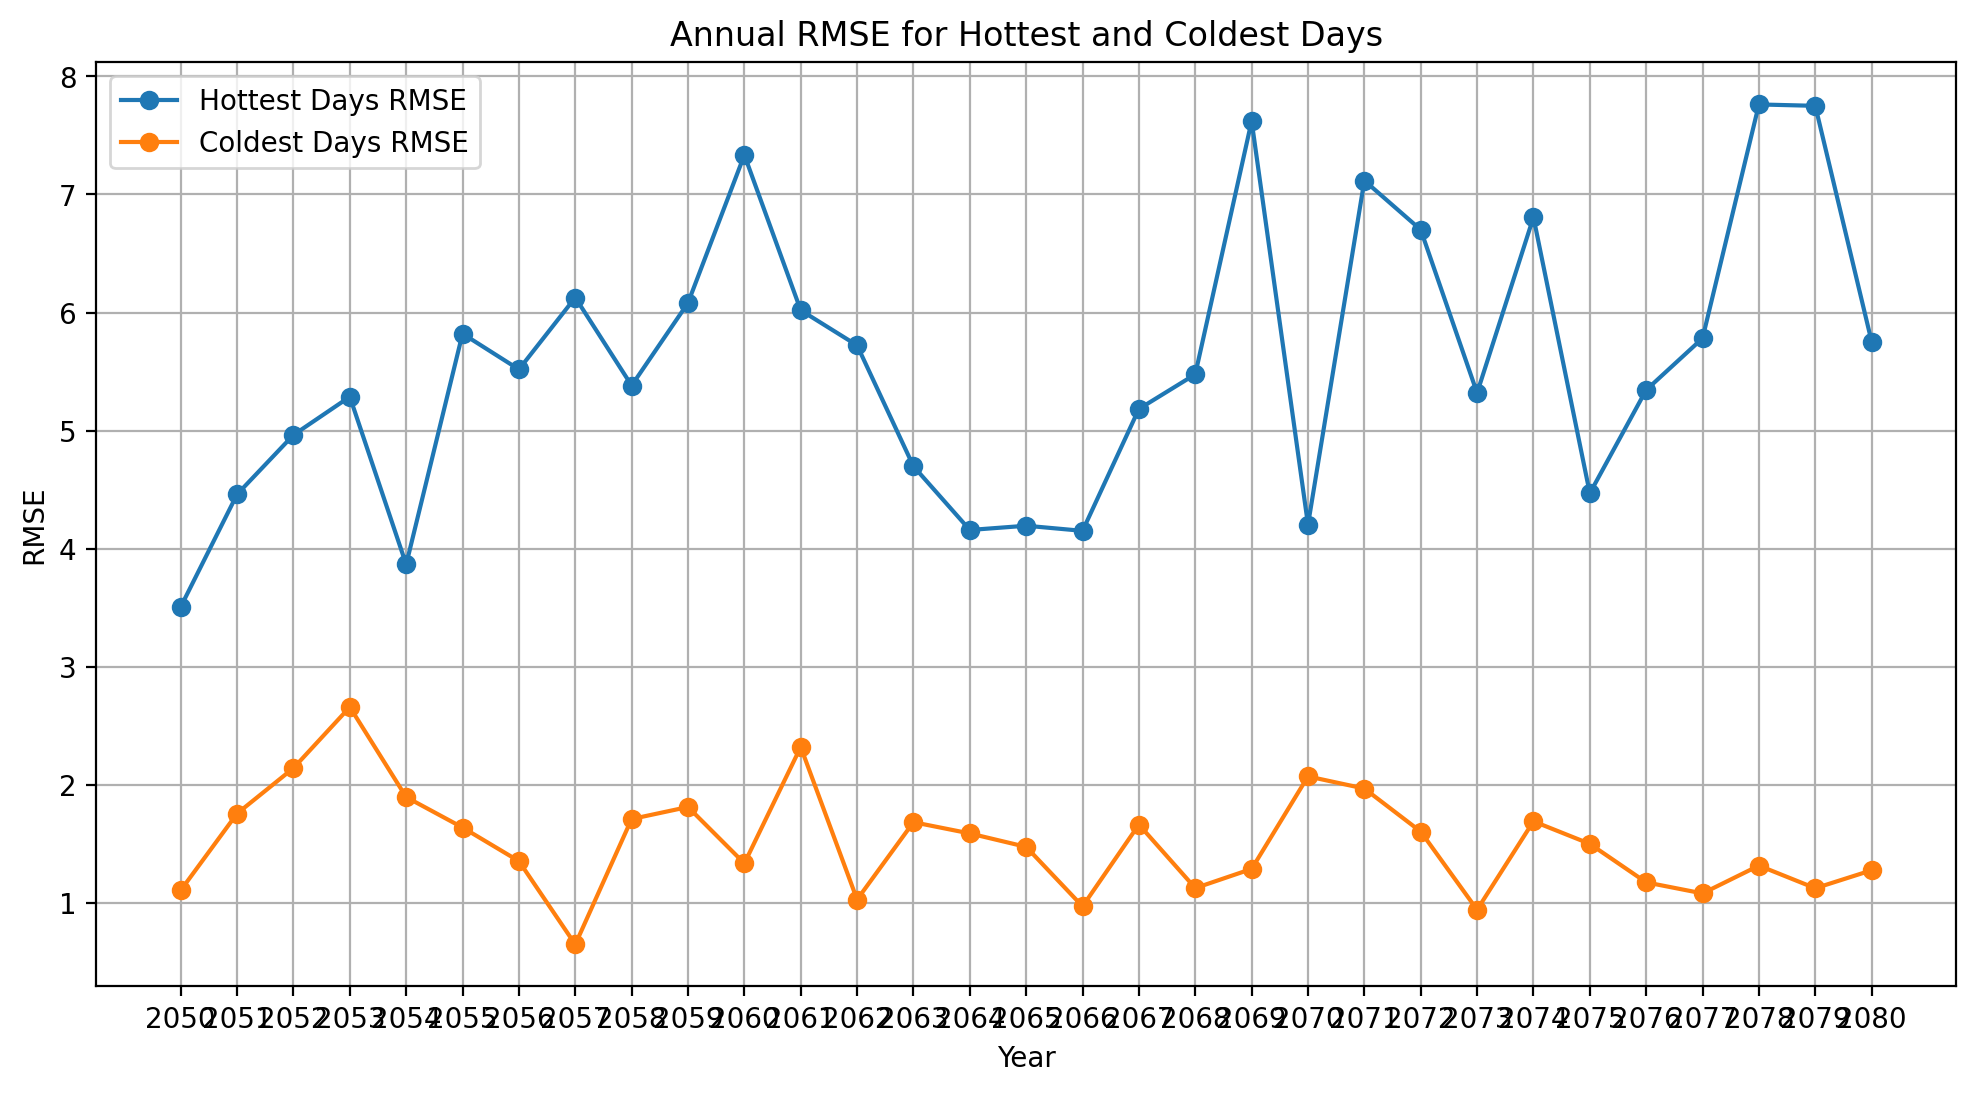

In [31]:

plt.figure(figsize=(12, 6))
plt.plot(results_df['year'], results_df['hottest_rmse'], label='Hottest Days RMSE', marker='o')
plt.plot(results_df['year'], results_df['coldest_rmse'], label='Coldest Days RMSE', marker='o')
plt.title('Annual RMSE for Hottest and Coldest Days')
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.xticks(results_df['year']) 
plt.show()


    year  year_rmse
0   2050   0.658950
1   2051   0.646217
2   2052   0.652675
3   2053   0.659451
4   2054   0.668626
5   2055   0.670434
6   2056   0.678799
7   2057   0.679905
8   2058   0.688715
9   2059   0.688600
10  2060   0.679484
11  2061   0.683677
12  2062   0.702146
13  2063   0.694024
14  2064   0.698935
15  2065   0.715937
16  2066   0.711000
17  2067   0.727663
18  2068   0.720515
19  2069   0.726910
20  2070   0.738353
21  2071   0.743046
22  2072   0.751244
23  2073   0.748199
24  2074   0.767961
25  2075   0.759240
26  2076   0.773087
27  2077   0.786047
28  2078   0.773306
29  2079   0.786051
30  2080   0.795542


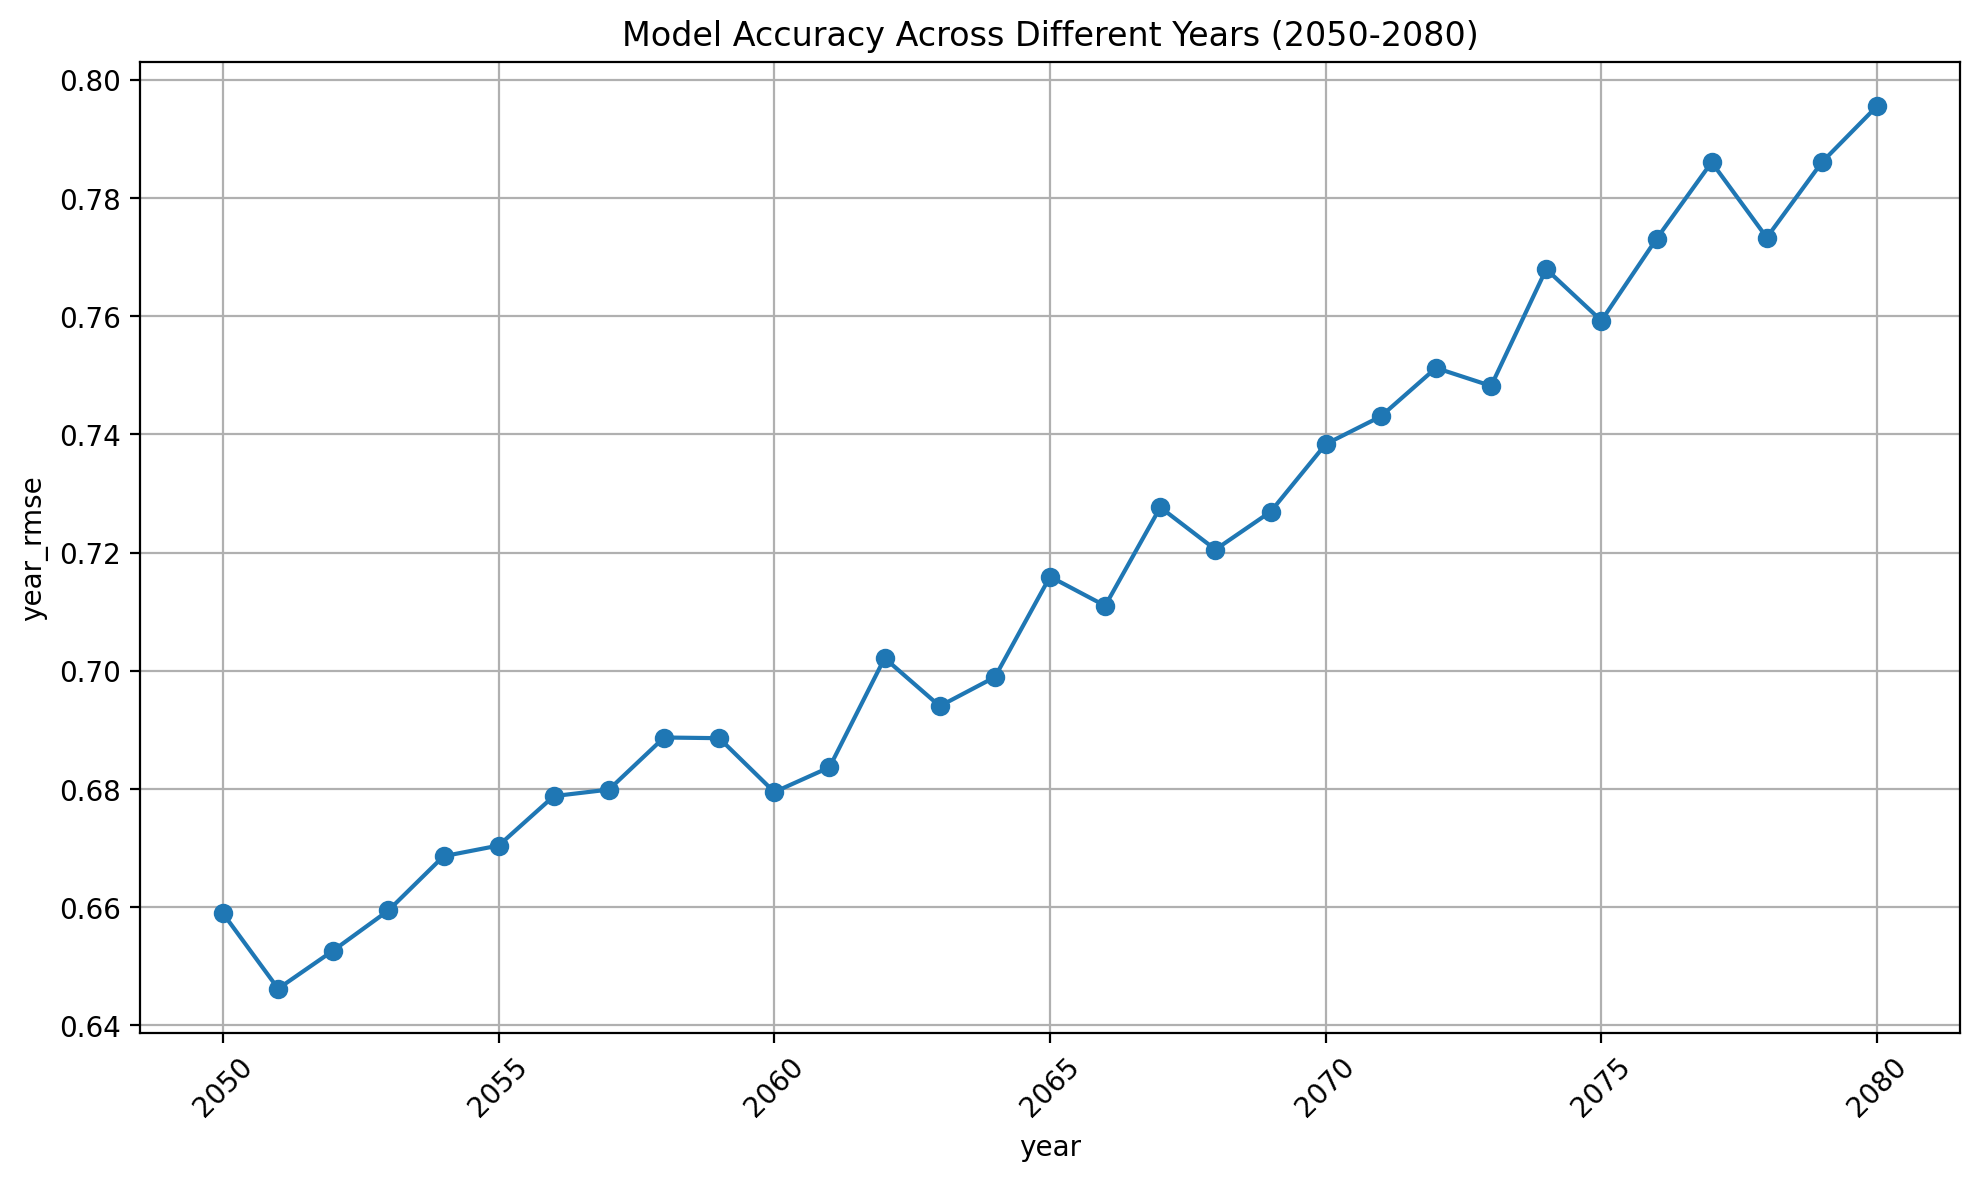

In [34]:
#periods
years = test['year'].unique()
results = []
for year in years:
    year_data = test[(test['year'] == year)]
    year_rmse = calculate_rmse(year_data['TREFMXAV_U'], year_data['predict'])
    
    results.append({
        'year': year,
        'year_rmse': year_rmse
    })

rmse_df = pd.DataFrame(results)
print(rmse_df)

plt.figure(figsize=(10, 6))
plt.plot(rmse_df['year'], rmse_df['year_rmse'], label='RMSE by Year', marker='o', linestyle='-')
plt.title('Model Accuracy Across Different Years (2050-2080)')
plt.xlabel('year')
plt.ylabel('year_rmse')
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()